# DQN-Pendulum

In [16]:
import matplotlib
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


In [17]:
import random
import numpy as np
import collections
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [18]:
try:
    device = torch.device("cuda:0")
    torch.zeros(1).to(device)
    print(f"成功使用 GPU: {torch.cuda.get_device_name(0)}")
except Exception as e:
    raise RuntimeError(f"无法正常使用 GPU 0: {e} 。")

成功使用 GPU: NVIDIA GeForce RTX 4050 Laptop GPU


# 环境 Pendulum-v1

In [19]:
import gymnasium as gym
env_name = 'Pendulum-v1'
env = gym.make(env_name)

# DQN

## 经验回放

In [20]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)     # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):   # 查看目前buffer中数据的数量
        return len(self.buffer)

## Q网络

In [21]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

## DQN算法

In [22]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,epsilon, target_update, device):
        self.action_dim = action_dim

        self.q_net = Qnet(state_dim, hidden_dim,self.action_dim).to(device)  # Q网络
        self.target_q_net = Qnet(state_dim, hidden_dim,self.action_dim).to(device) # 目标网络
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate) # 使用Adam优化器,只优化主网络的参数
        # target_q_net的都没有优化器，也不反向传播，不更新参数，只复制q_net的参数。

        self.gamma = gamma      # 折扣因子
        self.epsilon = epsilon
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0          # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-greedy策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor(np.array(state), dtype=torch.float).to(self.device)
            with torch.no_grad():
                action = self.q_net(state).argmax().item()     #输入state给q_net,获得q
        return action


    def update(self, transition_dict):
        # 转为tensor
        states = torch.tensor(np.array(transition_dict['states']),dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']),dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        with torch.no_grad():                             # 下个状态的最大Q值
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)     #Q_target

        dqn_loss = F.mse_loss(q_values, q_targets)   # 均方误差损失函数

        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()         # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1

## 离散转连续
DQN只能输出离散的动作，所以要把离散的动作再转为具体的数值

In [23]:
class DiscreteToContinuous:
    def __init__(self, env, step_size):
        self.low, self.high = env.action_space.low[0], env.action_space.high[0]
        if not (0 < step_size <= self.high - self.low):
            raise ValueError("step_size must be in (0, high - low]")

        vals = self.low + np.arange(int(np.floor((self.high - self.low) / step_size)) + 1) * step_size
        if vals[-1] < self.high:
            vals = np.append(vals, self.high)

        self.values = vals.astype(np.float32)
        self.action_dim = len(self.values)

    def get_discrete_action_dim(self):
        return self.action_dim

    def to_continuous(self, discrete_action):
        if not 0 <= discrete_action < self.action_dim:
            raise IndexError("discrete_action out of range")
        return np.array([self.values[discrete_action]], dtype=np.float32)

# 训练

## 实例化

In [24]:
step_size = 0.2
discrete_to_continuous = DiscreteToContinuous(env,step_size)
#=========================================================
buffer_size = 5000
replay_buffer = ReplayBuffer(buffer_size)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
#===================================================
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim =discrete_to_continuous.get_discrete_action_dim()
lr = 1e-3
gamma = 0.98
epsilon = 0.1
target_update = 50
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,target_update, device)

## 训练函数

In [25]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,batch_size,discrete_to_continuous):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state , info = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    action_continuous = discrete_to_continuous.to_continuous(action)  #这里输出的已经是一维np.array了

                    next_state, reward, terminated, truncated, info = env.step(action_continuous)
                    done = terminated or truncated  # terminated和truncated得到值为True或Fasle
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        # b_s,b_ns是二维np.aarray,其他是元组，查看replay_buffer.sample()源码
                        transition_dict = {'states': b_s,'actions': b_a,'next_states': b_ns,
                                            'rewards': b_r,'dones': b_d }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({'episode':'%d' % (num_episodes / 10 * i + i_episode + 1),
                                        'return':'%.3f' % np.mean(return_list[-10:])            })
                pbar.update(1)
    return return_list

## 开始训练

In [26]:
num_episodes = 1000
minimal_size = 1000
batch_size = 64
return_list= train_DQN(agent, env, num_episodes,replay_buffer, minimal_size,batch_size,discrete_to_continuous)

Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 1:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 2:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 3:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 4:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 5:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 6:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 7:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 8:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 9:   0%|          | 0/100 [00:00<?, ?it/s]

## 训练结束

### 保存网络参数

In [27]:
torch.save(agent.target_q_net.state_dict(), 'dqn_pendulum_target_q_net.pth')

### 训练过程可视化

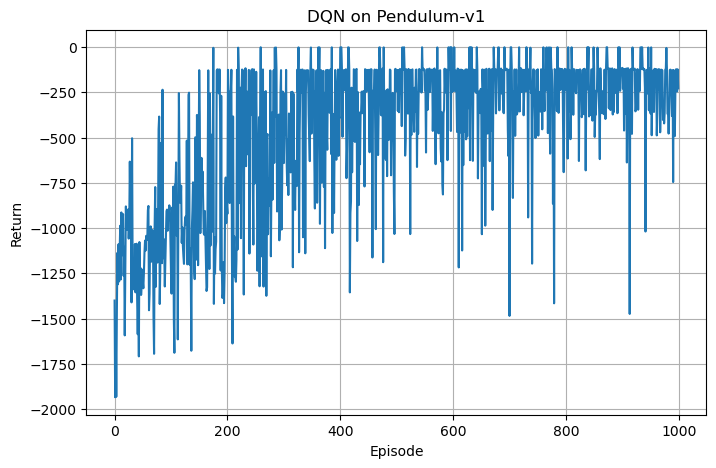

In [28]:
### 训练过程可视化
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(return_list)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('DQN on Pendulum-v1')
plt.grid(True)
plt.show()